In [1]:
import datetime

import numpy             as np
import matplotlib.pyplot as plt

from CCfun  import in_range
from CCfun  import filter_df
from CCfun  import longer_than_exwl
from CCfun  import find_crystal_position
from CCfun  import remove_spikes

from CCfit  import fit
from CCfit  import polynom
from CCfit  import gauss_poly
from CCfit  import double_gauss_poly
from CCfit  import triple_gauss_poly

from CCplot import auto_plot_style
from CCplot import plot1d
from CCplot import plot2d

from CCio import load_and_process
from CCio import load_references_from_h5

In [2]:
%matplotlib inline

auto_plot_style({"lines.linewidth": 2, "font.size":20})

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
def calculate_irradiation_times(dates):
    dates = np.asarray(dates[1:])
    dates = dates.reshape(dates.size // 2, 2)
    return [t[0].total_seconds() / 3600 for t in np.diff(dates, axis=1)]

def load(filename, i):
    print(filename)
    df = load_and_process(filename, i).crystals
    df = filter_df(df, crystal=7)
    return df.groupby("state", as_index=False)\
             .apply(remove_spikes)\
             .reset_index(drop=True)

# All data

In [5]:
dates = [
datetime.datetime(2020, 6, 23,  1, 47), # Scan BaF crystals
datetime.datetime(2020, 6, 23,  4, 44), # Irradiating Crystal 7 (BaF)
datetime.datetime(2020, 6, 25,  2, 41), # Scan BaF crystals
datetime.datetime(2020, 6, 25,  5, 41), # Irradiating Crystal 7 (BaF)
datetime.datetime(2020, 6, 27, 21,  3), # Scan BaF crystals

]

irradiation_times = calculate_irradiation_times(dates)
irrad_time  = np.cumsum(np.append([0], irradiation_times))

In [6]:
irradiation_times

[45.95, 63.36666666666667]

In [7]:
filenames = ["/home/gonzalo/data/CC/cs137_irrad_baf_2020_06_23_01_47_50_963000.h5",
             "/home/gonzalo/data/CC/cs137_irrad_baf_2020_06_25_02_41_06_530000.h5",
             "/home/gonzalo/data/CC/cs137_irrad_baf_2020_06_27_21_03_20_423000.h5",
            ]

dfs  = [load(filename, i) for i, filename in enumerate(filenames)]
refs = [load_references_from_h5(filename) for i, filename in enumerate(filenames)]

/home/gonzalo/data/CC/cs137_irrad_baf_2020_06_23_01_47_50_963000.h5
/home/gonzalo/data/CC/cs137_irrad_baf_2020_06_25_02_41_06_530000.h5
/home/gonzalo/data/CC/cs137_irrad_baf_2020_06_27_21_03_20_423000.h5


Text(0.5, 1.0, 'Reference Spphire')

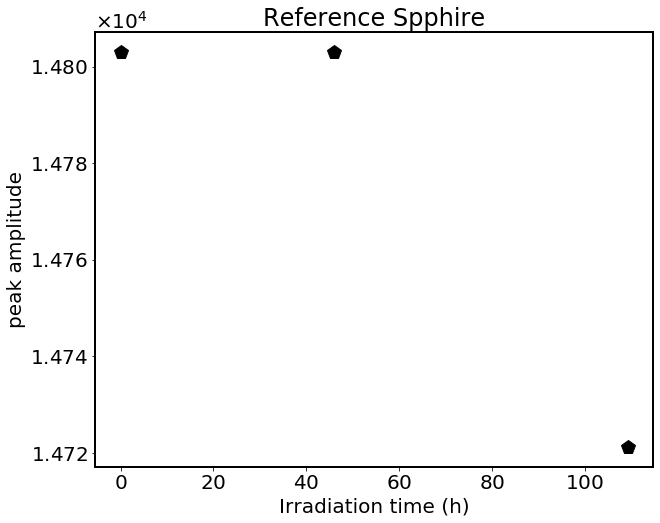

In [8]:
maxs = []

for i, df in enumerate(refs):
    df = filter_df(df, crystal=0)
    #plt.plot(df.em_wl, df.counts / df.power, label=str(i))
    maxs.append((df.counts).quantile(0.99))
plt.figure()
plt.plot(irrad_time, maxs, "p")
plt.xlabel("Irradiation time (h)")
plt.ylabel("peak amplitude")
plt.title("Reference Spphire")

Text(0.5, 1.0, 'Reference Spphire')

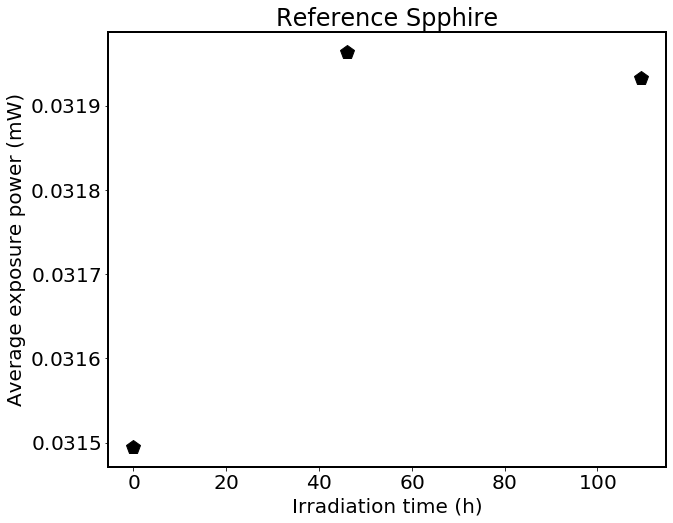

In [9]:
pows = []

for i, df in enumerate(refs):
    df = filter_df(df, crystal=0)
    pows.append(df.power.mean() *1e3)

plt.plot(irrad_time, pows, "p")
plt.xlabel("Irradiation time (h)")
plt.ylabel("Average exposure power (mW)")
plt.title("Reference Spphire")

In [10]:
dfs[0].head()

full_scan  crystal  grating  exp_index  slit_width  state  exposure  ex_wl  \
0       True        7        2          0        1000     59       0.2  800.0   
1       True        7        2          0        1000     59       0.2  800.0   
2       True        7        2          0        1000     59       0.2  800.0   
3       True        7        2          0        1000     59       0.2  800.0   
4       True        7        2          0        1000     59       0.2  800.0   

          power           timestamp  em_wl  counts  crystal_id crystal_type  \
0  4.166852e-07 2020-06-23 00:45:46  833.5  3067.0  BaF_B1_187          BaF   
1  4.166852e-07 2020-06-23 00:45:46  834.0  3060.0  BaF_B1_187          BaF   
2  4.166852e-07 2020-06-23 00:45:46  834.5  3057.0  BaF_B1_187          BaF   
3  4.166852e-07 2020-06-23 00:45:46  835.0  3055.0  BaF_B1_187          BaF   
4  4.166852e-07 2020-06-23 00:45:46  835.5  3059.0  BaF_B1_187          BaF   

   bkgsub  rate       quantar       dquanta  wheel_no  
0     2.0  10.0  1.678298e+14  5.958416e-14         0  
1   -13.0 -65.0  1.678298e+14 -3.872970e-13         0  
2    -4.0 -20.0  1.678298e+14 -1.191683e-13         0  
3   -11.0 -55.0  1.678298e+14 -3.277129e-13         0  
4   -11.0 -55.0  1.678298e+14 -3.277129e-13         0

# All wavelengths

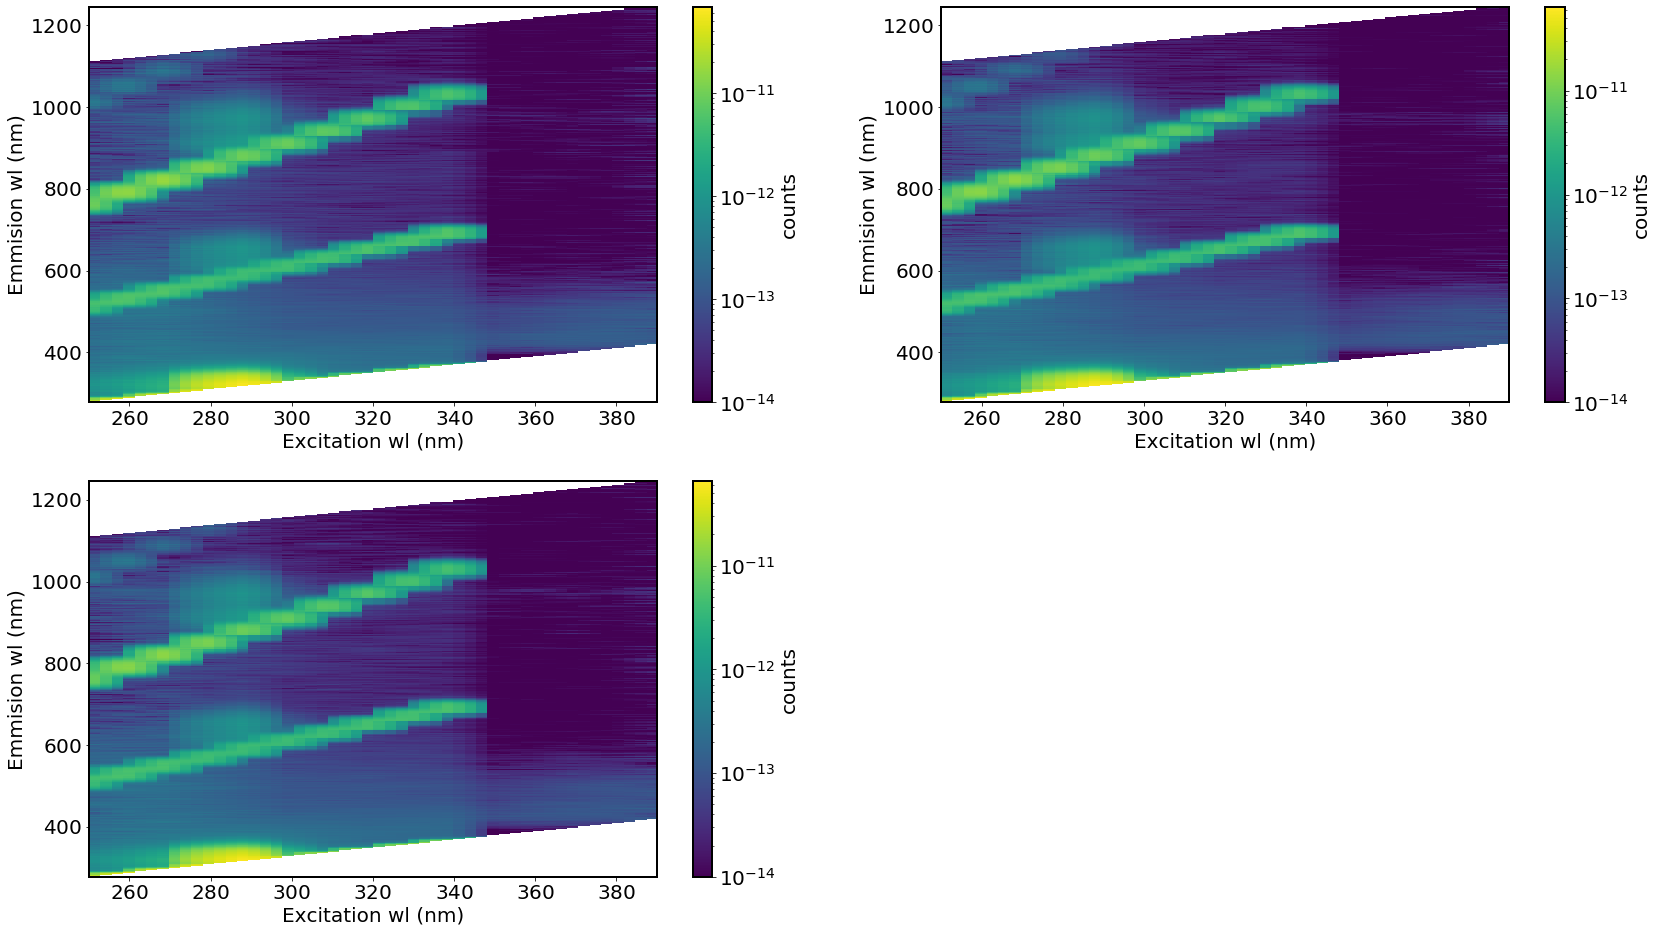

In [13]:
nhalf = (len(dfs) + 1) // 2
plt.figure(figsize=(28, 8*nhalf))

for n, df in enumerate(dfs):
    df = filter_df(df, grating=1, exposure=2)
    plt.subplot(nhalf, 2, n+1)
    plot2d(df.ex_wl, df.em_wl, np.clip(df.dquanta, 1e-14, np.inf), log=True)


/home/gonzalo/sw/anaconda3/envs/CC/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


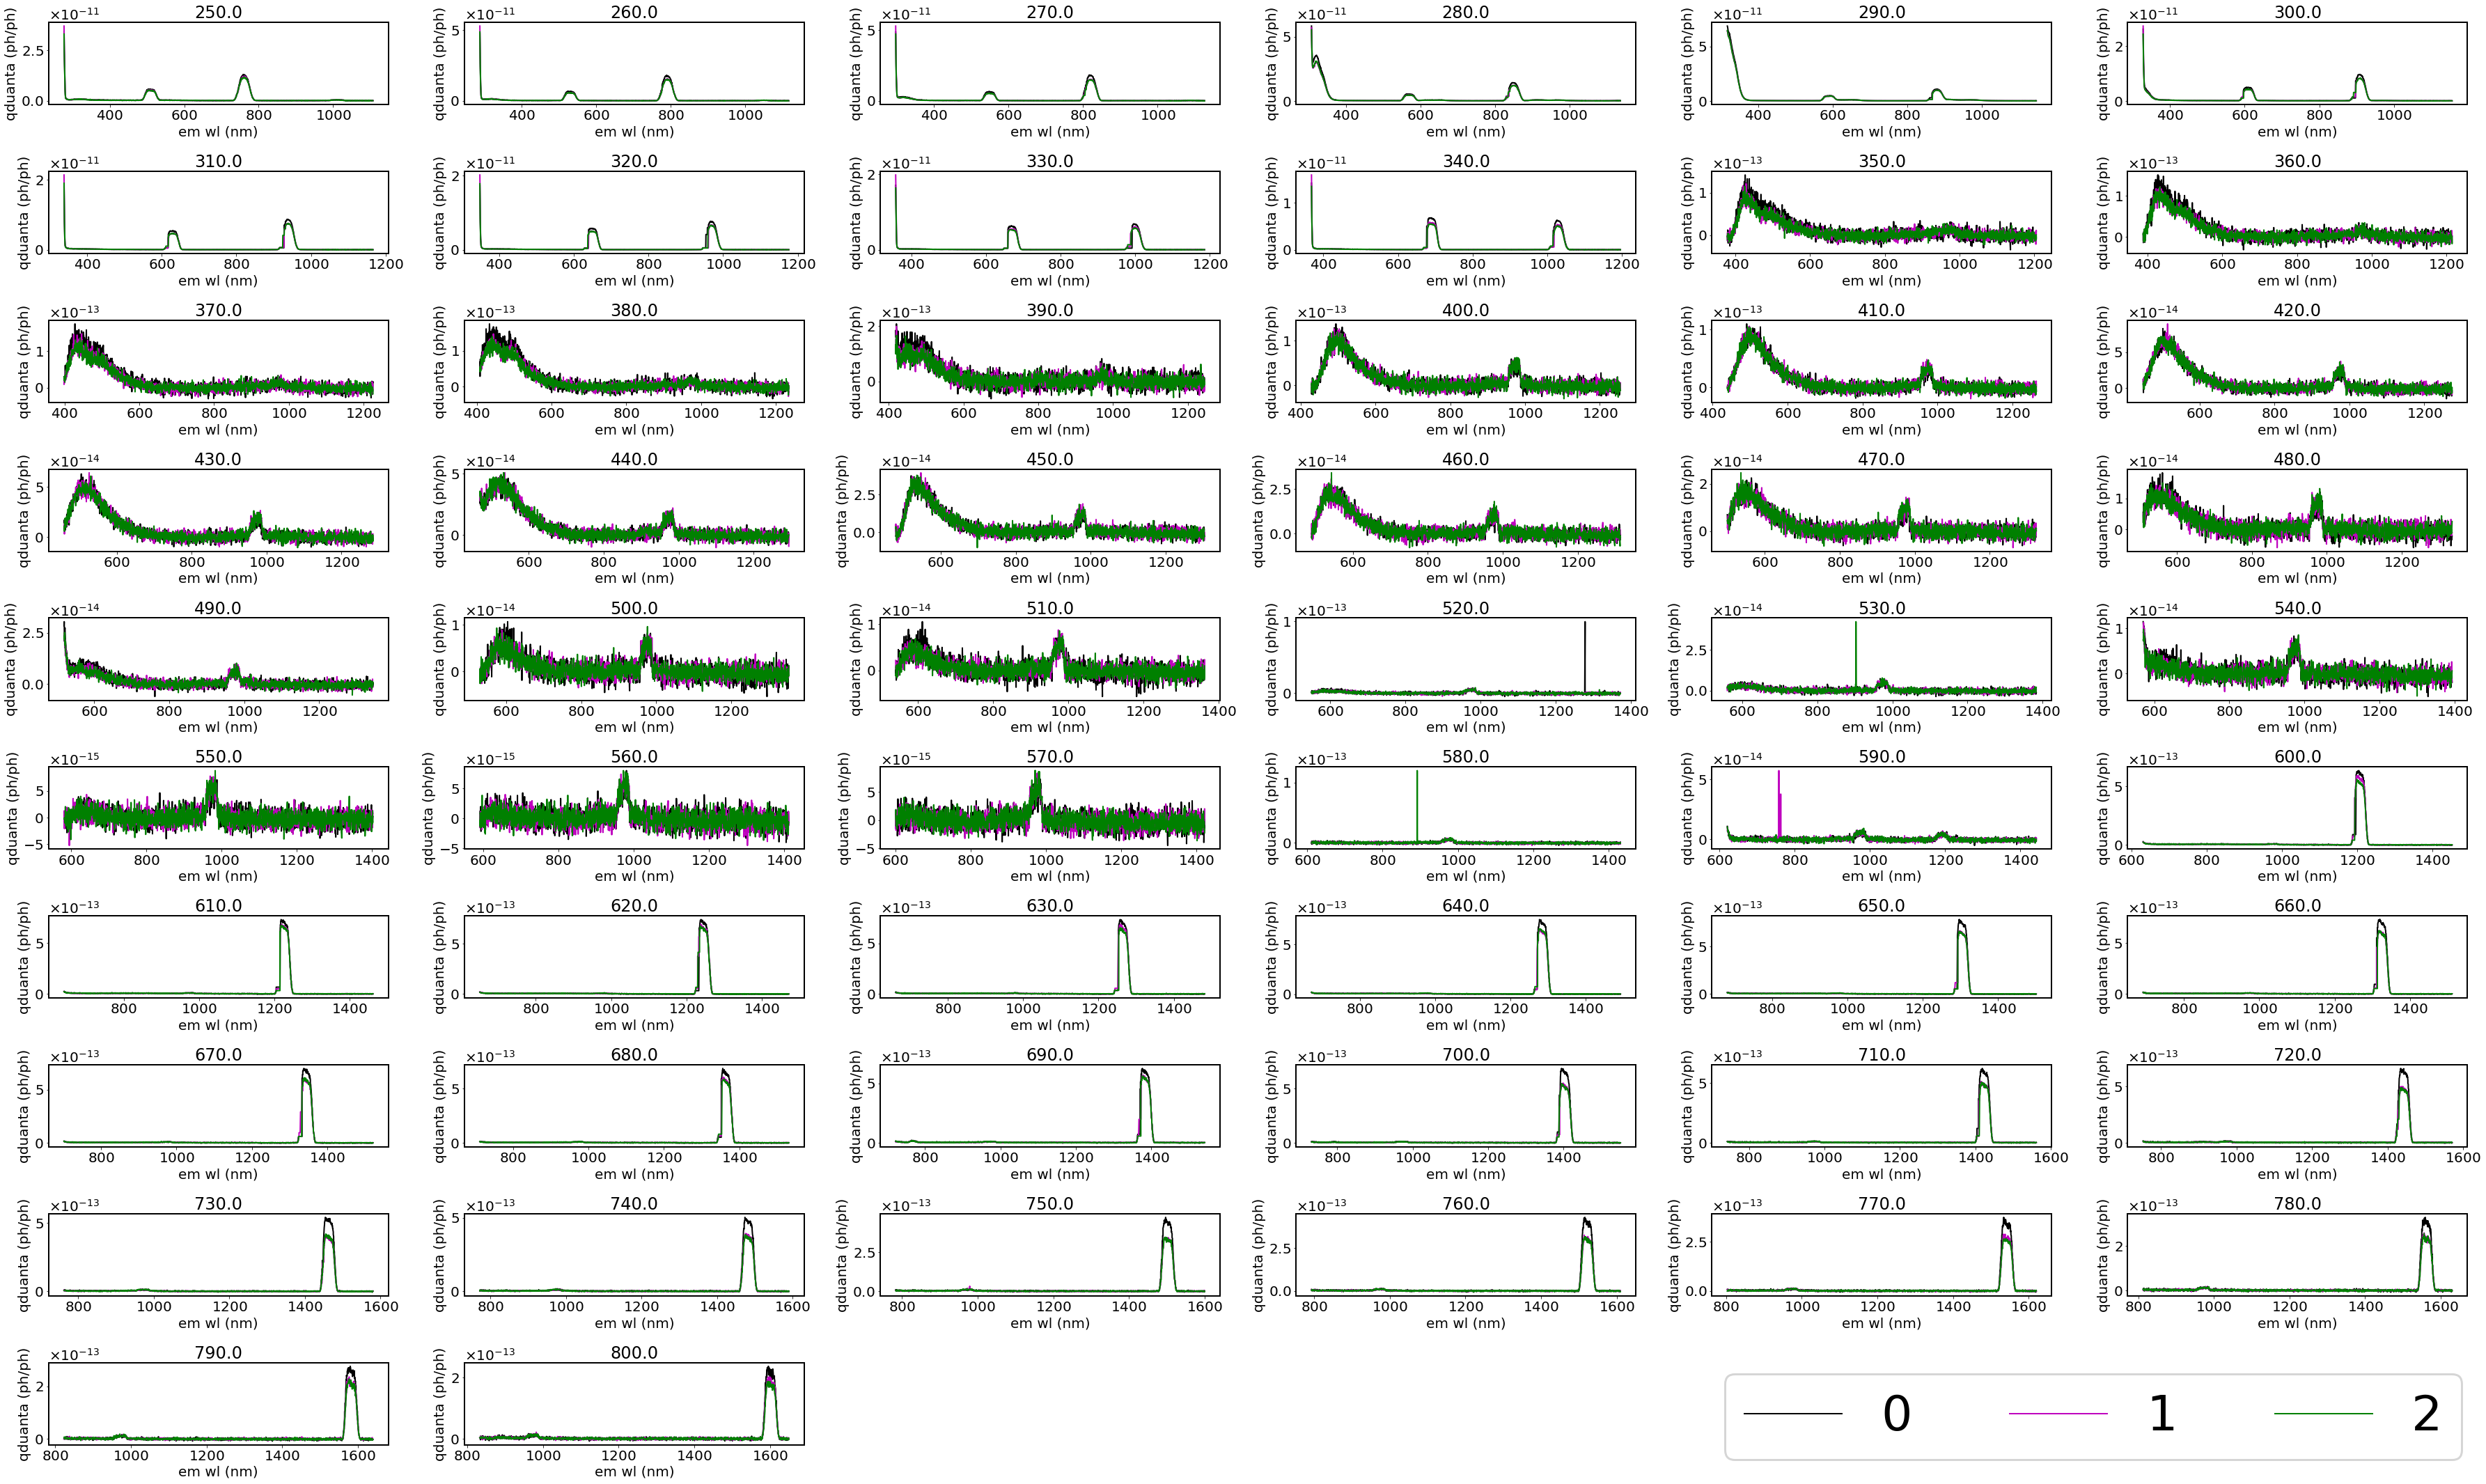

In [14]:
plt.figure(figsize=(10*5, 6*5))

for n, df in enumerate(dfs):
    groups = filter_df(df, exposure=2).groupby("ex_wl")

    for k, (ex_wl, data) in enumerate(groups, start=1):
        plt.subplot(10, 6, k)
        data = data.loc[data.grating == 1 + int(ex_wl >= 400)]
        plt.plot(data.em_wl, data.dquanta, label=str(n), lw=2)
        
        if n == 0:
            plt.xlabel("em wl (nm)")
            plt.ylabel("qduanta (ph/ph)")
            plt.title (str(ex_wl))

handles, labels = plt.gca().get_legend_handles_labels()
plt.gcf().legend(handles, labels, loc="lower right", prop={'size': 70}, ncol=len(dfs))

plt.tight_layout()

# 320 nm

Text(0, 0.5, 'qduanta (ph/ph)')

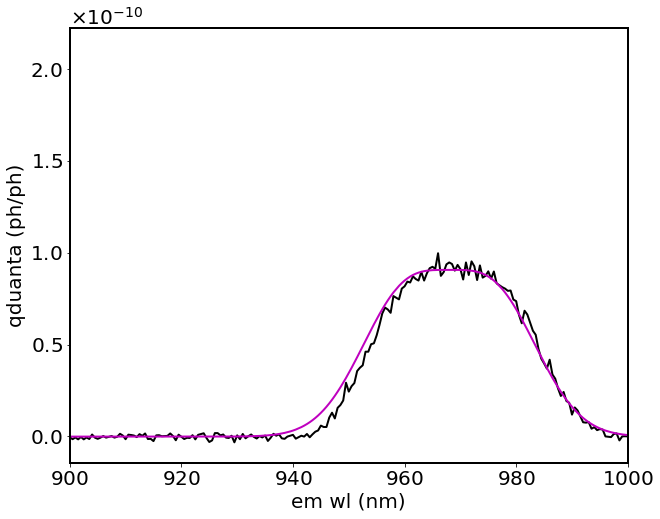

In [33]:
data = filter_df(dfs[0], crystal=7, grating=1, exposure=.2, ex_wl=320)
plt.plot(data.em_wl, data.dquanta, lw=2)

seed = 1.5e-9, 960, 8,  1.5e-9, 976, 8, -1.1e-13

plt.plot(data.em_wl, double_gauss_poly(data.em_wl, *seed))

plt.xlim(900, 1000)
#plt.ylim(0, 3e-13)
plt.xlabel("em wl (nm)")
plt.ylabel("qduanta (ph/ph)")

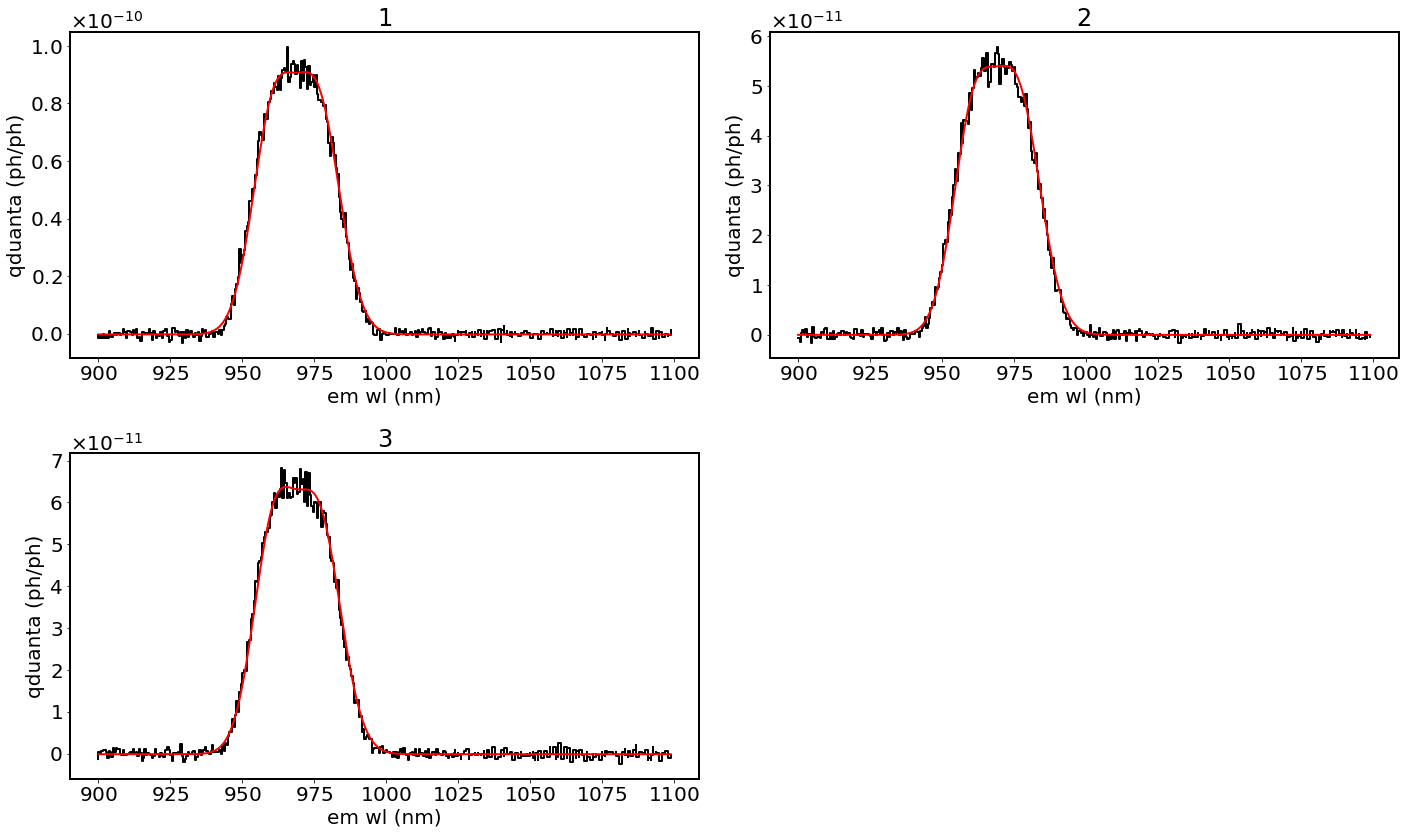

In [36]:
nhalf = int(np.ceil(len(dfs)/2))

plt.figure(figsize=(10*2, 6*nhalf))

fit_values = []

for n, df in enumerate(dfs, start=1):
    data = filter_df(df, crystal=7, grating=1, exposure=.2, ex_wl=320)
    data = data[in_range(data.em_wl, 900, 1100)]

    seed = 1.5e-9, 960, 8,  1.5e-9, 976, 8, -1.1e-13
    f    = fit(double_gauss_poly, data.em_wl.values, data.dquanta.values,
               seed      = seed,
               maxfev    = 10**5)

    fit_values.append(f.values)
    
    plt.subplot(nhalf, 2, n)
    plt.plot(data.em_wl, data.dquanta, label=str(n), drawstyle="steps")
    plt.plot(data.em_wl, f.fn(data.em_wl), "r-")

    plt.xlabel("em wl (nm)")
    plt.ylabel("qduanta (ph/ph)")
    plt.title (str(n))

plt.tight_layout()

fit_values = np.stack(fit_values)

In [40]:
irrad_time  = np.cumsum(np.append([0], irradiation_times))
a1, m1, s1, a2, m2, s2, c = fit_values.T 

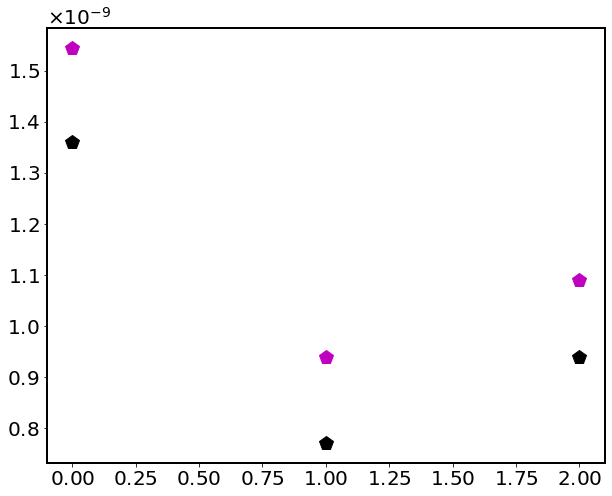

In [41]:
plt.plot(np.arange(len(a1)), a1, "p");
plt.plot(np.arange(len(a2)), a2, "p");

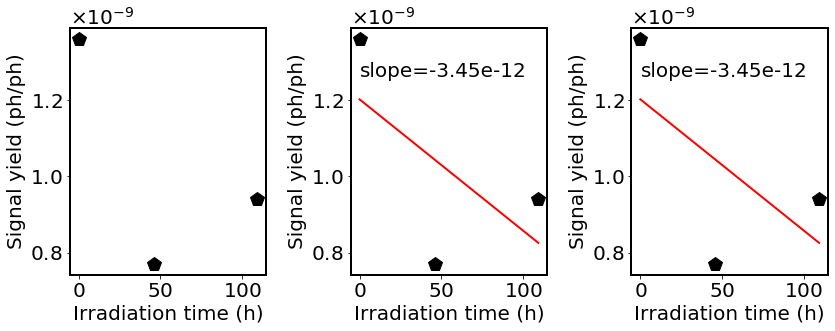

In [43]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
s  = slice(None)
plt.plot(irrad_time[s], a1[s], "p")
plt.xlabel("Irradiation time (h)")
plt.ylabel("Signal yield (ph/ph)")

plt.subplot(1, 3, 2)
f  = fit(polynom, irrad_time[s], a1[s], (0, 1))
plt.plot(irrad_time[s], a1[s], "p", label=f"$I_1$: {f.values[0]:.2e} + {f.values[1]:.2e} t")
plt.plot(irrad_time[s], f.fn(irrad_time[s]), "-r")
plt.xlabel("Irradiation time (h)")
plt.ylabel("Signal yield (ph/ph)")
plt.text(0.05, .8, f"slope={f.values[1]:.2e}", transform=plt.gca().transAxes)

plt.subplot(1, 3, 3)
f  = fit(polynom, irrad_time[s], a1[s], (0, 1))
plt.plot(irrad_time[s], a1[s], "p", label=f"$I_1$: {f.values[0]:.2e} + {f.values[1]:.2e} t")
plt.plot(irrad_time[s], f.fn(irrad_time[s]), "-r")
plt.xlabel("Irradiation time (h)")
plt.ylabel("Signal yield (ph/ph)")
plt.text(0.05, .8, f"slope={f.values[1]:.2e}", transform=plt.gca().transAxes)


plt.tight_layout()

Text(0, 0.5, 'Peak centroid (nm)')

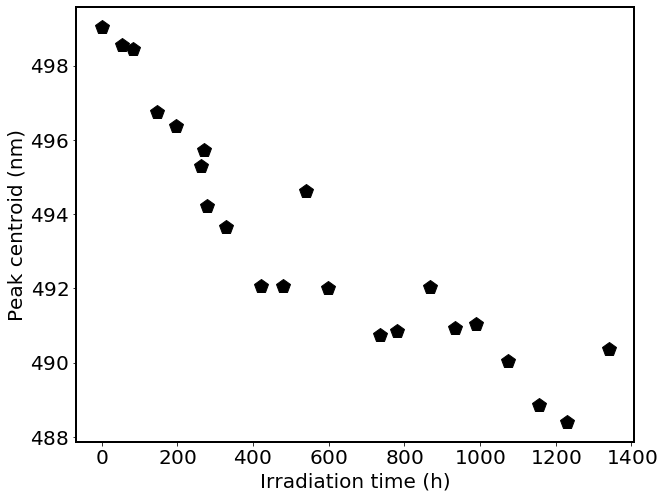

In [17]:
plt.plot(irrad_time, m1, "pk", label="$\mu_1$")
plt.xlabel("Irradiation time (h)")
plt.ylabel("Peak centroid (nm)")

Text(0, 0.5, 'Peak width (nm)')

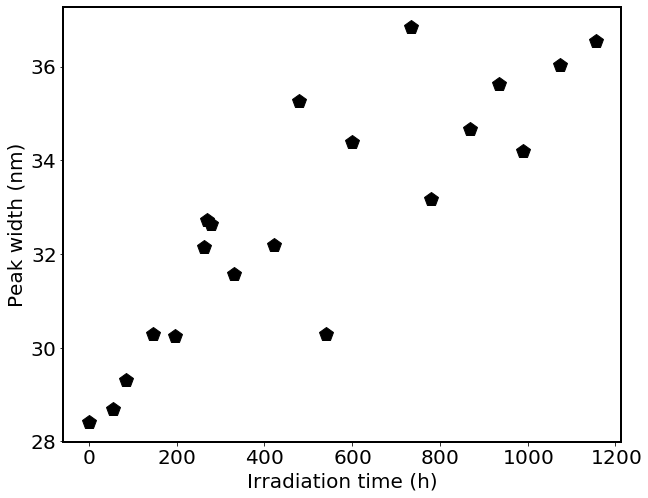

In [18]:
plt.plot(irrad_time, s1, "pk", label="$\sigma_1$")
plt.xlabel("Irradiation time (h)")
plt.ylabel("Peak width (nm)")

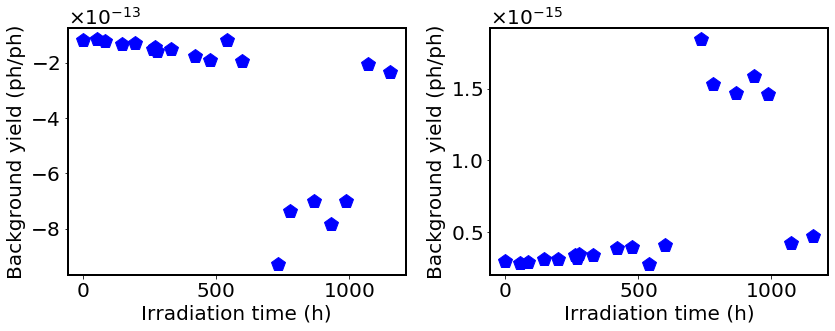

In [19]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(irrad_time, p11, "pb")
plt.xlabel("Irradiation time (h)")
plt.ylabel("Background yield (ph/ph)");

plt.subplot(1, 2, 2)
plt.plot(irrad_time, p12, "pb")
plt.xlabel("Irradiation time (h)")
plt.ylabel("Background yield (ph/ph)");

plt.tight_layout()

# 600 nm

Text(0, 0.5, 'qduanta (ph/ph)')

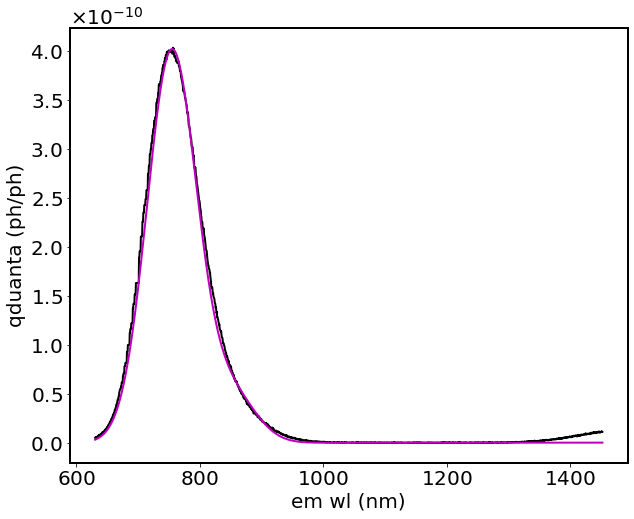

In [20]:
data = filter_df(dfs[0], crystal=10, grating=2, exposure=.2, ex_wl=600)
plt.plot(data.em_wl, data.dquanta, lw=2)

seed = 4e-8, 755, 40, 5e-9, 850, 40, -1.1e-13, 3e-16

plt.plot(data.em_wl, double_gauss_poly(data.em_wl, *seed))

plt.xlabel("em wl (nm)")
plt.ylabel("qduanta (ph/ph)")

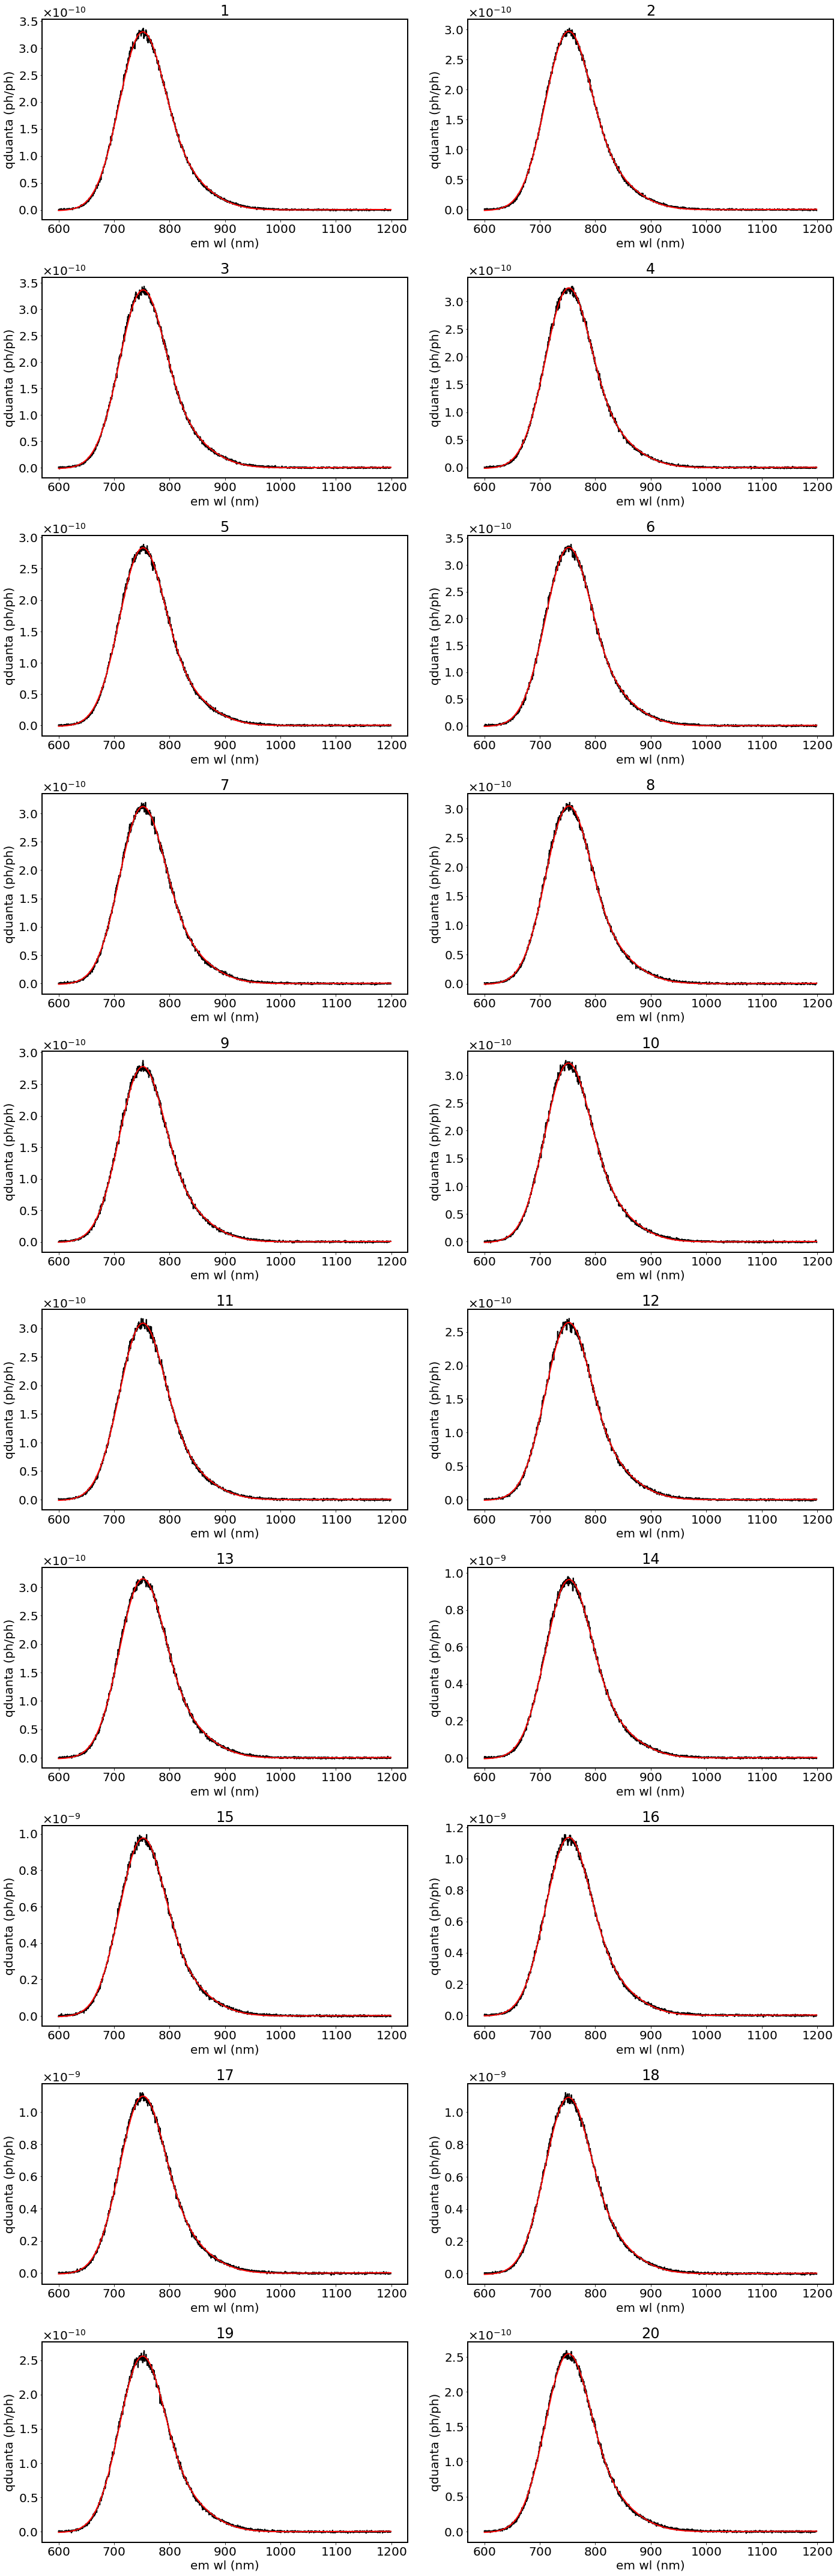

In [21]:
nhalf = int(np.ceil(len(dfs)/2))

plt.figure(figsize=(10*2, 6*nhalf))

fit_values = []

for n, df in enumerate(dfs, start=1):
    data = filter_df(df, crystal=10, grating=2, exposure=.2, ex_wl=410)
    data = data[in_range(data.em_wl, 600, 1200)]

    seed = 4e-8, 755, 40, 5e-9, 850, 40, -1.1e-13, 3e-16
    f    = fit(double_gauss_poly, data.em_wl.values, data.dquanta.values,
               seed      = seed,
               maxfev    = 10**5)

    fit_values.append(f.values)
    
    plt.subplot(nhalf, 2, n)
    plt.plot(data.em_wl, data.dquanta, label=str(n), drawstyle="steps")
    plt.plot(data.em_wl, f.fn(data.em_wl), "r-")

    plt.xlabel("em wl (nm)")
    plt.ylabel("qduanta (ph/ph)")
    plt.title (str(n))

plt.tight_layout()

fit_values = np.stack(fit_values)

In [22]:
irrad_time  = np.cumsum(np.append([0], irradiation_times))
a1, m1, s1, a2, m2, s2, p11, p12 = fit_values.T 

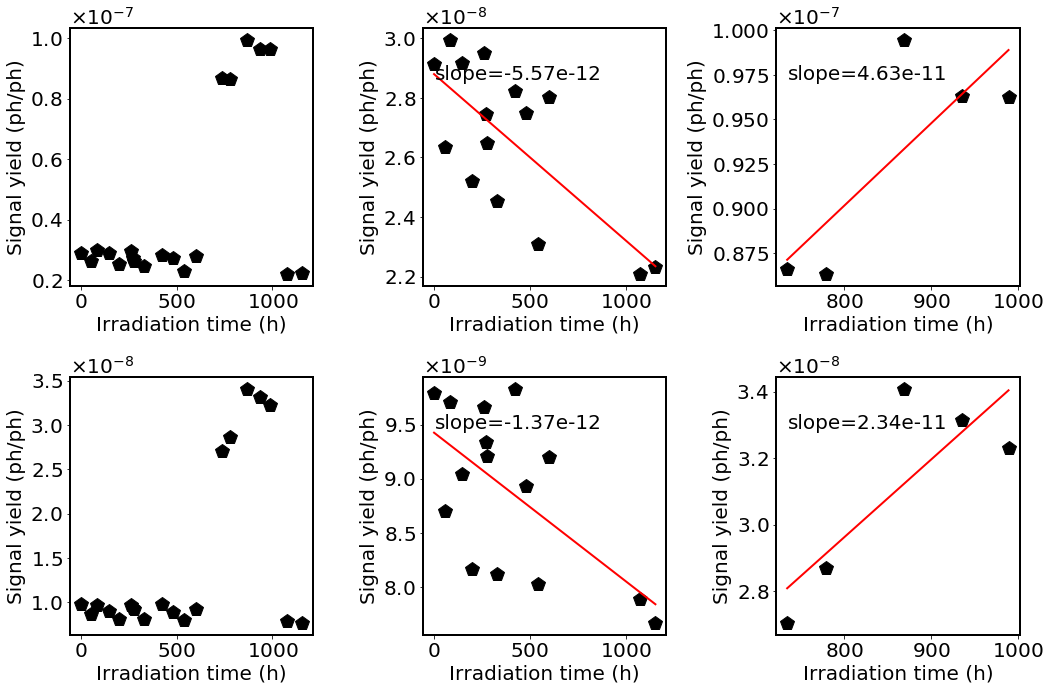

In [23]:
plt.figure(figsize=(15, 10))
for k, a in enumerate([a1, a2]):
    plt.subplot(2, 3, 1 + 3*k)
    s  = slice(None)
    plt.plot(irrad_time[s], a[s], "p")
    plt.xlabel("Irradiation time (h)")
    plt.ylabel("Signal yield (ph/ph)")

    plt.subplot(2, 3, 2 + 3*k)
    s  = [True]*13 + [False] * 5 + [True] * (len(a1) - 18)
    f  = fit(polynom, irrad_time[s], a[s], (0, 1))
    plt.plot(irrad_time[s], a[s], "p", label=f"$I_1$: {f.values[0]:.2e} + {f.values[1]:.2e} t")
    plt.plot(irrad_time[s], f.fn(irrad_time[s]), "-r")
    plt.xlabel("Irradiation time (h)")
    plt.ylabel("Signal yield (ph/ph)")
    plt.text(0.05, .8, f"slope={f.values[1]:.2e}", transform=plt.gca().transAxes)

    plt.subplot(2, 3, 3 + 3*k)
    s  = [not si for si in s]
    f  = fit(polynom, irrad_time[s], a[s], (0, 1))
    plt.plot(irrad_time[s], a[s], "p", label=f"$I_1$: {f.values[0]:.2e} + {f.values[1]:.2e} t")
    plt.plot(irrad_time[s], f.fn(irrad_time[s]), "-r")
    plt.xlabel("Irradiation time (h)")
    plt.ylabel("Signal yield (ph/ph)")
    plt.text(0.05, .8, f"slope={f.values[1]:.2e}", transform=plt.gca().transAxes)


plt.tight_layout()

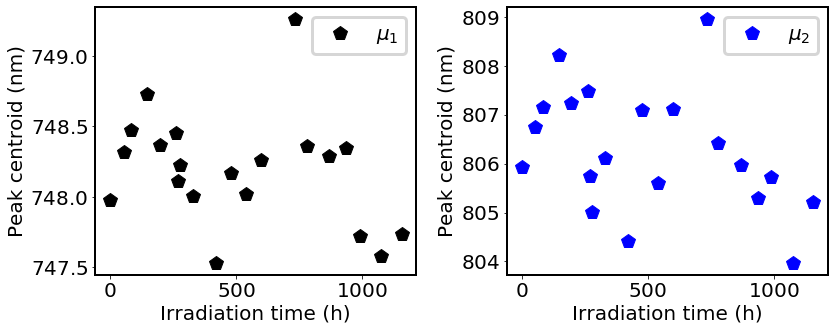

In [24]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(irrad_time, m1, "pk", label="$\mu_1$")
plt.legend()
plt.xlabel("Irradiation time (h)")
plt.ylabel("Peak centroid (nm)")

plt.subplot(1, 2, 2)
plt.plot(irrad_time, m2, "pb", label="$\mu_2$")
plt.legend()
plt.xlabel("Irradiation time (h)")
plt.ylabel("Peak centroid (nm)")

plt.tight_layout()

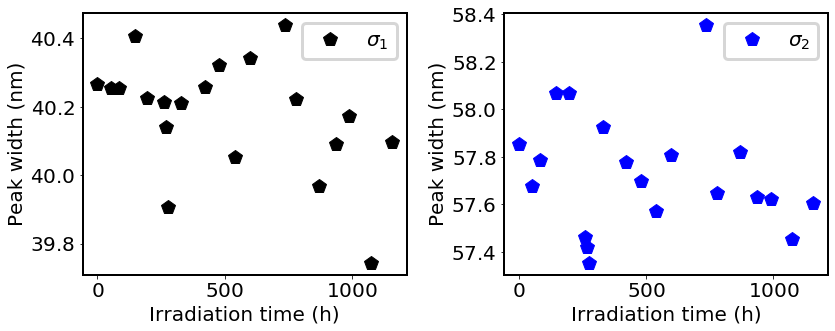

In [25]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(irrad_time, s1, "pk", label="$\sigma_1$")
plt.legend()
plt.xlabel("Irradiation time (h)")
plt.ylabel("Peak width (nm)")

plt.subplot(1, 2, 2)
plt.plot(irrad_time, s2, "pb", label="$\sigma_2$")
plt.legend()
plt.xlabel("Irradiation time (h)")
plt.ylabel("Peak width (nm)")

plt.tight_layout()

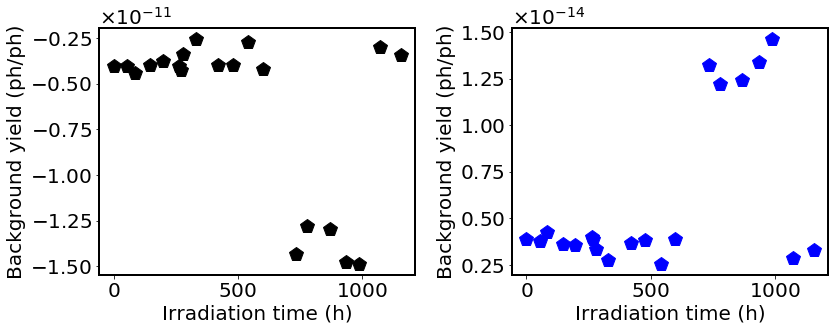

In [26]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(irrad_time, p11, "pk")
plt.xlabel("Irradiation time (h)")
plt.ylabel("Background yield (ph/ph)");

plt.subplot(1, 2, 2)
plt.plot(irrad_time, p12, "pb")
plt.xlabel("Irradiation time (h)")
plt.ylabel("Background yield (ph/ph)");

plt.tight_layout()

# 400 nm

Text(0, 0.5, 'qduanta (ph/ph)')

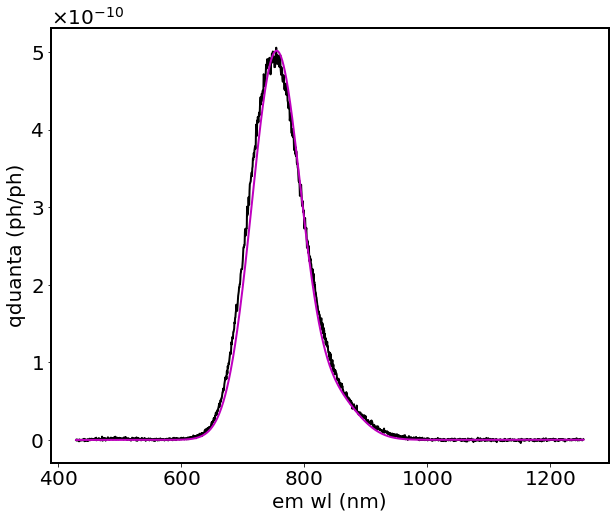

In [27]:
data = filter_df(dfs[0], crystal=10, grating=2, exposure=.2, ex_wl=400)
plt.plot(data.em_wl, data.dquanta, lw=2)

seed = 5e-8, 755, 40, 5e-9, 850, 40, -1.1e-13, 3e-16

plt.plot(data.em_wl, double_gauss_poly(data.em_wl, *seed))

plt.xlabel("em wl (nm)")
plt.ylabel("qduanta (ph/ph)")

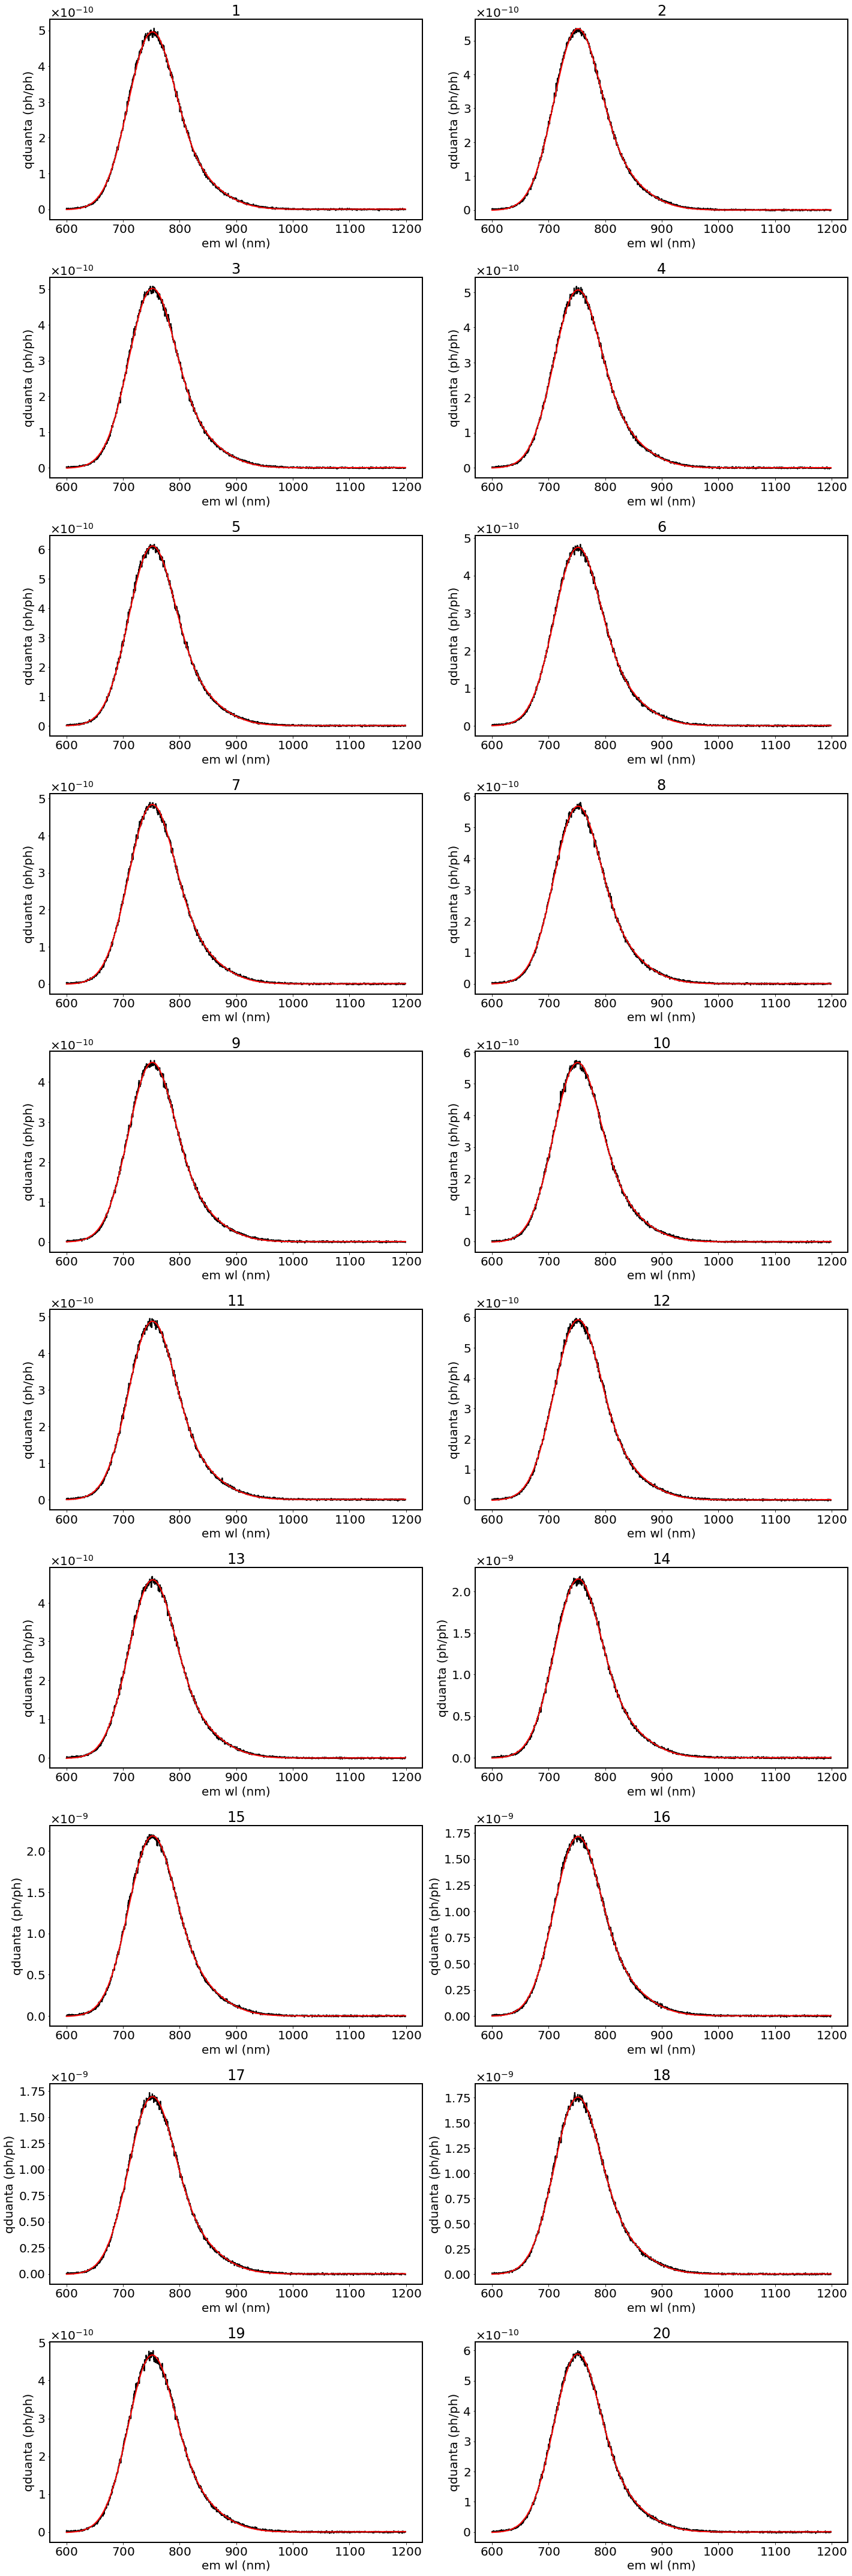

In [28]:
nhalf = int(np.ceil(len(dfs)/2))

plt.figure(figsize=(10*2, 6*nhalf))

fit_values = []

for n, df in enumerate(dfs, start=1):
    data = filter_df(df, crystal=10, grating=2, exposure=.2, ex_wl=400)
    data = data[in_range(data.em_wl, 600, 1200)]

    seed = 5e-8, 755, 40, 5e-9, 850, 40, -1.1e-13, 3e-16
    f    = fit(double_gauss_poly, data.em_wl.values, data.dquanta.values,
               seed      = seed,
               maxfev    = 10**5)

    fit_values.append(f.values)
    
    plt.subplot(nhalf, 2, n)
    plt.plot(data.em_wl, data.dquanta, label=str(n), drawstyle="steps")
    plt.plot(data.em_wl, f.fn(data.em_wl), "r-")

    plt.xlabel("em wl (nm)")
    plt.ylabel("qduanta (ph/ph)")
    plt.title (str(n))

plt.tight_layout()

fit_values = np.stack(fit_values)

In [29]:
irrad_time  = np.cumsum(np.append([0], irradiation_times))
a1, m1, s1, a2, m2, s2, p11, p12 = fit_values.T 

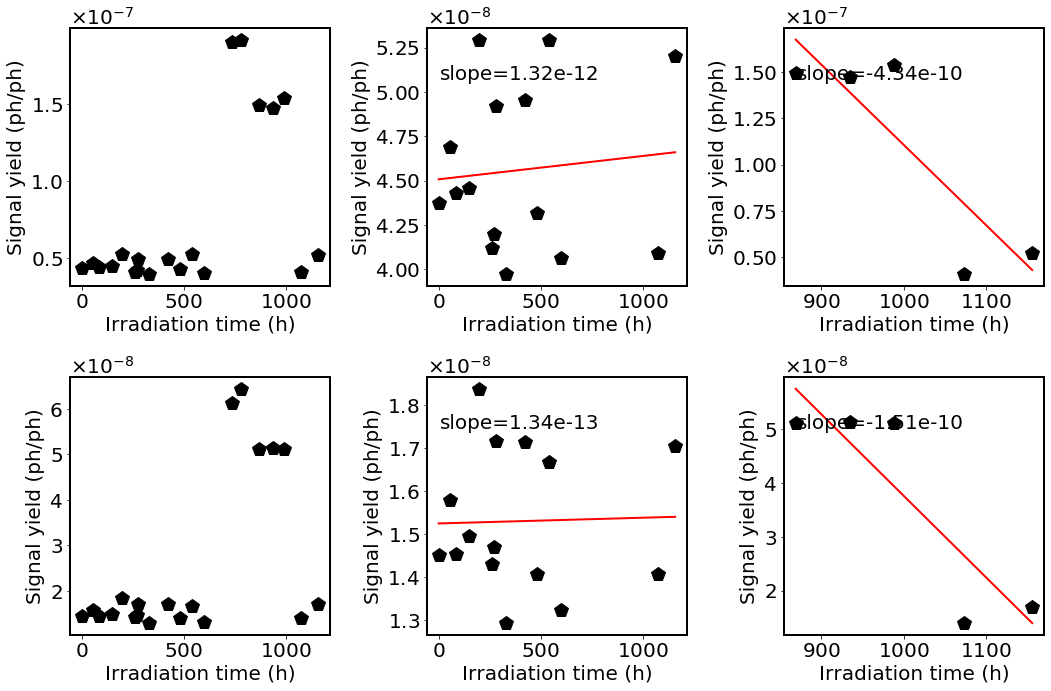

In [30]:
plt.figure(figsize=(15, 10))
for k, a in enumerate([a1, a2]):
    plt.subplot(2, 3, 1 + 3*k)
    s  = slice(None)
    plt.plot(irrad_time[s], a[s], "p")
    plt.xlabel("Irradiation time (h)")
    plt.ylabel("Signal yield (ph/ph)")

    plt.subplot(2, 3, 2 + 3*k)
    s  = [True]*13 + [False] * 5 + [True] * (len(a1) - 18)
    f  = fit(polynom, irrad_time[s], a[s], (0, 1))
    plt.plot(irrad_time[s], a[s], "p", label=f"$I_1$: {f.values[0]:.2e} + {f.values[1]:.2e} t")
    plt.plot(irrad_time[s], f.fn(irrad_time[s]), "-r")
    plt.xlabel("Irradiation time (h)")
    plt.ylabel("Signal yield (ph/ph)")
    plt.text(0.05, .8, f"slope={f.values[1]:.2e}", transform=plt.gca().transAxes)

    plt.subplot(2, 3, 3 + 3*k)
    s  = [False]*15 + [True] * 3 + [True] * (len(a1) - 18)
    f  = fit(polynom, irrad_time[s], a[s], (0, 1))
    plt.plot(irrad_time[s], a[s], "p", label=f"$I_1$: {f.values[0]:.2e} + {f.values[1]:.2e} t")
    plt.plot(irrad_time[s], f.fn(irrad_time[s]), "-r")
    plt.xlabel("Irradiation time (h)")
    plt.ylabel("Signal yield (ph/ph)")
    plt.text(0.05, .8, f"slope={f.values[1]:.2e}", transform=plt.gca().transAxes)


plt.tight_layout()

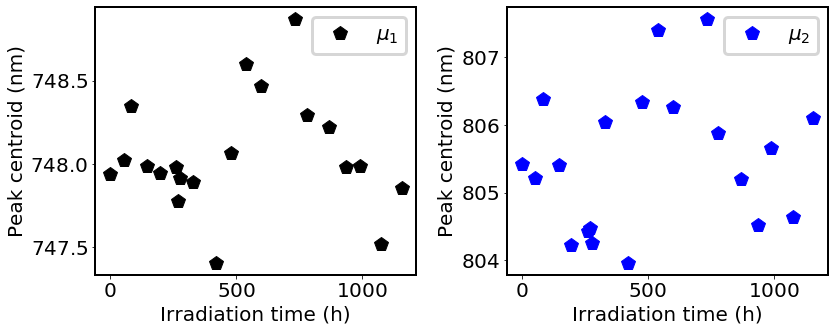

In [31]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(irrad_time, m1, "pk", label="$\mu_1$")
plt.legend()
plt.xlabel("Irradiation time (h)")
plt.ylabel("Peak centroid (nm)")

plt.subplot(1, 2, 2)
plt.plot(irrad_time, m2, "pb", label="$\mu_2$")
plt.legend()
plt.xlabel("Irradiation time (h)")
plt.ylabel("Peak centroid (nm)")

plt.tight_layout()

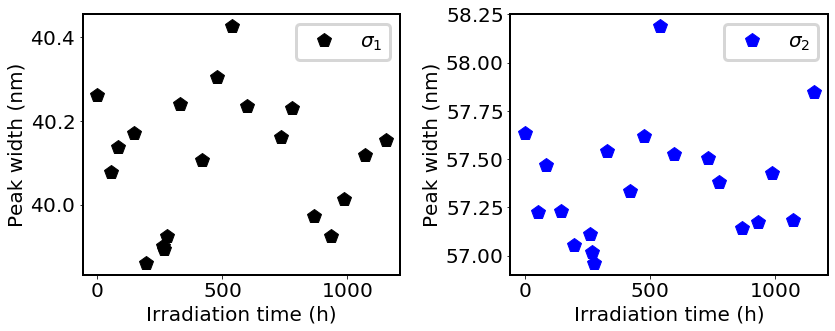

In [32]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(irrad_time, s1, "pk", label="$\sigma_1$")
plt.legend()
plt.xlabel("Irradiation time (h)")
plt.ylabel("Peak width (nm)")

plt.subplot(1, 2, 2)
plt.plot(irrad_time, s2, "pb", label="$\sigma_2$")
plt.legend()
plt.xlabel("Irradiation time (h)")
plt.ylabel("Peak width (nm)")

plt.tight_layout()

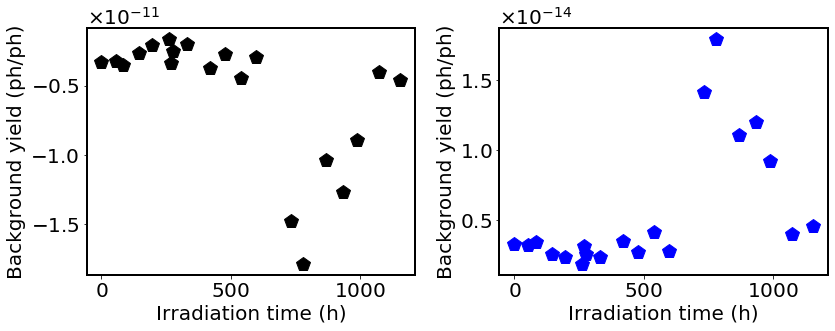

In [33]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(irrad_time, p11, "pk")
plt.xlabel("Irradiation time (h)")
plt.ylabel("Background yield (ph/ph)");

plt.subplot(1, 2, 2)
plt.plot(irrad_time, p12, "pb")
plt.xlabel("Irradiation time (h)")
plt.ylabel("Background yield (ph/ph)");

plt.tight_layout()